# DBSCAN Exploration 

Here I will try to explore segmentation using DBSCAN. The advantage of using DBSCAN is that it doesn't require specifying number of clusters like K-means. It can find any shape of clusters no matter how weird, which is ideal for spatial data like images. It is also great with outliers or noise as suggested by the name. The only parameters are radius of clusters and the minimum of data within each cluster.

Core Points: A data point p is a core point if Nbhd(p,ɛ) [ɛ-neighborhood of p] contains at least minPts ; |Nbhd(p,ɛ)| >= minPts.

Border Points: A data point *q is a border point if Nbhd(q, ɛ) contains less than minPts data points, but q is reachable from some core point p.

Outlier: A data point o is an outlier if it is neither a core point nor a border point. Essentially, this is the "other" class.

In [259]:
import numpy as np 

import matplotlib.pyplot as plt
import os
import re
import cv2
from scipy.misc import imresize
from u_net_functions import dice_coef, dice_coef_loss, jacc_coef, jacc_coef_loss, jacc_coef_int, get_unet
from collections import OrderedDict, Counter

import scipy.ndimage as ndimage

%matplotlib inline

## View Image and Original Mask

In [578]:
dir_path = 'training_tiles_1000size/'
np_files = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path) 
             for f in files if (f.endswith('img.npy'))]

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


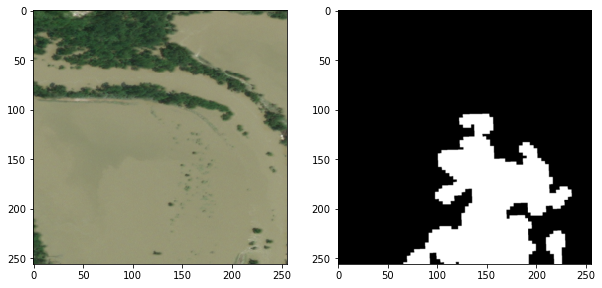

In [762]:
tile = 'training_tiles_1000size/Train/8908'

img = imresize(np.load(tile+'_img.npy'),(256,256))
MDA_mask = imresize(np.load(tile+'_mask.npy'),(256,256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img)
ax2.imshow(MDA_mask,cmap=plt.cm.gray)

# Experimentation 

## Hypertuning 

There's two parameters for DBSCAN, radius (epsilon) and minimum of points per cluster. The higher the minimum of points, the more noise and density reachable points, and less core points. The same for epsilon as it decreases. If epsilon is too low or minimum of points too high, the low resolution will produce false negatives

To choose optimal epsilon, I will plot a sorted K Nearest Neighbors distance plot to look for an "elbow region". Here K is the same as the minimum of points per cluster.

Minimum of points is determinded based on the size of the image. In this case: M x N / 256 for greyscale images. 256x256/(256*3) = 85

In [664]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors= 85 ).fit(Z)
distances, indices = nbrs.kneighbors(Z)
distances.sort(axis=0)

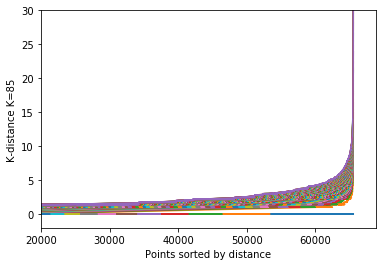

In [665]:
plt.plot(distances.argsort(axis=0), distances)
plt.ylim(ymax=30)
plt.xlim(xmin=20000)
plt.ylabel("K-distance K=85")
plt.xlabel("Points sorted by distance")

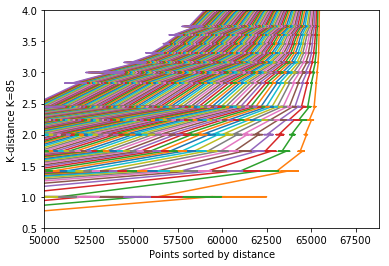

In [667]:
#Let's zoom in more
plt.plot(distances.argsort(axis=0), distances)
plt.ylim(ymax=4,ymin=0.5)
plt.xlim(xmin=50000)
plt.ylabel("K-distance K=85")
plt.xlabel("Points sorted by distance")

As you can see from the plot, the medium elbow region is around when distance is between 2.5 and 1. I'll be using 1.75, 1.5, and 1.25.

## Fitting and Viewing DBSCAN

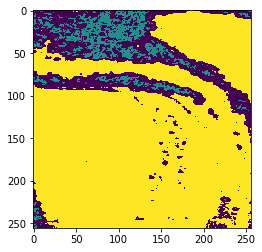

In [670]:
from sklearn.cluster import DBSCAN

Z = img.reshape((-1,3))
Z = np.float32(Z)
db = DBSCAN(eps=1.75,min_samples=85,n_jobs=-1).fit(Z)
dimension = int(db.labels_.shape[0]**0.5)
mask_clustered = np.reshape(db.labels_,(dimension,dimension))
plt.imshow(mask_clustered)

## Color Filters

In [671]:
dimension = int(img.shape[0])
mask_clustered = np.reshape(db.labels_, (dimension,dimension))

#Ranking the most common clusters
most_common_clusters = Counter(mask_clustered.flatten()).most_common()
cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group
cluster_map

OrderedDict([(1, 49150), (0, 4491)])

### Flood Cluster

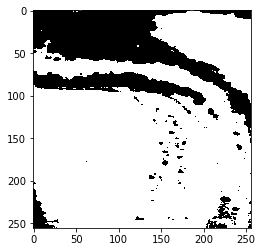

In [672]:
index = cluster_map.keys()[0]
plt.imshow(255*(mask_clustered==index),cmap=plt.cm.gray)

In [668]:
#Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))
rgb_sum

array([1080143, 1080812,  845204], dtype=uint64)

In [679]:
#If cluster is too white or black
rgb_sum.std()/rgb_sum.mean()

0.11068209745821074

For white/black/grey colors, the rgb channel should be identical or similar to each other.

So I will be setting a threshold for the Coefficient of variation. The standard Deviation of the RGB channels should high, otherwise it would be too white or black or grey.

In [321]:
#If cluster is too green
print "Green vs. Red: %r" % (float(rgb_sum[1])/rgb_sum[0]) 
print "Green vs Blue: %r" % (float(rgb_sum[1])/rgb_sum[2])

Green vs. Red: 0.99474081882340681
Green vs Blue: 1.2762586651401255


If the green channels are more prominent than the red channels, then cluster is most likely not flood. 

Brown colors go in this order of strength: Red > Green > Blue.

### Vegatation Cluster

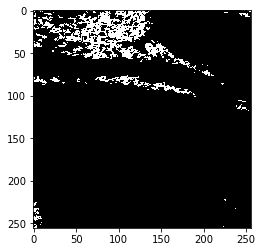

In [322]:
index = cluster_map.keys()[1]
plt.imshow(255*(mask_clustered==index),cmap=plt.cm.gray)

In [323]:
#Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))
rgb_sum

array([208004, 320219, 207721], dtype=uint64)

In [324]:
#If cluster is too white or black
rgb_sum.std()/rgb_sum.mean()

0.21590836279075853

In [325]:
#If cluster is too green
print "Green vs. Red: %r" % (float(rgb_sum[1])/rgb_sum[0]) 
print "Green vs Blue: %r" % (float(rgb_sum[1])/rgb_sum[2])

Green vs. Red: 1.5394848175996616
Green vs Blue: 1.5415822184564874


Unsurprisingly, the green channel is largest here

## Building Cluster

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


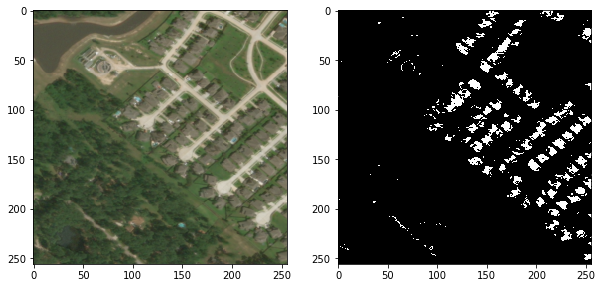

In [768]:
tile = 'training_tiles_1000size/Train/4252'
img = imresize(np.load(tile+'_img.npy'),(256,256))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img)
Z = img.reshape((-1,3))
Z = np.float32(Z)
db = DBSCAN(eps=1.55,min_samples=85,n_jobs=-1).fit(Z)
dimension = int(db.labels_.shape[0]**0.5)
mask_clustered = np.reshape(db.labels_,(dimension,dimension))
dimension = int(img.shape[0])
mask_clustered = np.reshape(db.labels_, (dimension,dimension))
#Ranking the most common clusters
most_common_clusters = Counter(mask_clustered.flatten()).most_common()
cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group
cluster_map

index = cluster_map.keys()[1]
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(255*(mask_clustered==index),cmap=plt.cm.gray)


In [746]:
#Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))
rgb_sum

array([352711, 409595, 260530], dtype=uint64)

In [747]:
#If cluster is too white or black
rgb_sum.std()/rgb_sum.mean()

0.18015083197616039

In [748]:
#If cluster is too green
print "Green vs. Red: %r" % (float(rgb_sum[1])/rgb_sum[0]) 
print "Green vs Blue: %r" % (float(rgb_sum[1])/rgb_sum[2])

Green vs. Red: 1.1612765124989013
Green vs Blue: 1.5721605957087474


Sometimes, there seems to be an issue isolating residential houses from flood, however some buildings can easily be filtered out with the white filter.

### Water

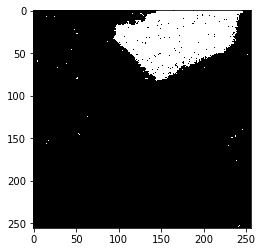

In [331]:
index = cluster_map.keys()[1]
plt.imshow(255*(mask_clustered==index),cmap=plt.cm.gray)

In [332]:
#Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))
rgb_sum

array([381881, 575475, 438645], dtype=uint64)

In [333]:
#If cluster is too white or black
rgb_sum.std()/rgb_sum.mean()

0.1746193732288244

In [334]:
#If cluster is too green
print "Green vs. Red: %r" % (float(rgb_sum[1])/rgb_sum[0]) 
print "Green vs Blue: %r" % (float(rgb_sum[1])/rgb_sum[2])

Green vs. Red: 1.5069484996635076
Green vs Blue: 1.3119378996682967


Natural water can be rejected with the green filter

# Functions: 

Recursive function to try multiple radius parameters.

In [765]:
def dbscan_train(img, epsilon=1.25, minpts=85):
    "Helper function that fits DBSCAN model to image and returns model object"
    Z = img.reshape((-1,3))
    Z = np.float32(Z)
    db = DBSCAN(eps=epsilon,min_samples=minpts,n_jobs=-1).fit(Z)
    return db
def dbscan_mask(img, db, count1=0, count2=0):
    "Actually creating the mask"
    #Number of Clusters 
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    dimension = int(img.shape[0])
    
    #Reshping labels into mask of clusters (feature map)
    mask_clustered = np.reshape(labels, (dimension,dimension))
    
    #If there's only 1 cluster, try a different epsilon
    if n_clusters_ == 1 and count1 ==0 and count2 == 0:
        count1+=1
        return dbscan_mask(img,dbscan_train(img, 1.75, 85),count1)
    elif n_clusters_ == 1 and count1 == 1 and count2 == 0:
        count1+=1
        return dbscan_mask(img,dbscan_train(img, 1.5, 85),count1)
    elif n_clusters_ == 1 and count1 > 1 and count2 == 0:
        return np.zeros((dimension,dimension)), mask_clustered, n_clusters_
    
    else:
        #Ranking the most common clusters
        most_common_clusters = Counter(mask_clustered.flatten()).most_common()
        cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group

        #Filtering out clusters that are too white, black, or green.
        #Initialization mask
        new_mask = np.zeros((dimension,dimension))
        #Going through each cluster
        for index in cluster_map.keys():
            if len(cluster_map.keys()) == 0:
                break

            #Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
            rgb_sum = (img * np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))

            #If cluster is too white or black
            if float(rgb_sum.std())/rgb_sum.mean() < 0.11:
                #print("Too white or black",index,count1,count2)
                continue

            #If cluster is too green
            if float(rgb_sum[1])/rgb_sum[0] > 1.1 :
                #print("Too much vegatation",index,count1,count2)
                continue
            
            #If all else goes well
            else:
                new_mask = 255 * (mask_clustered==index)
                #print("Not filtered: ",index,count1,count2,db)
                break

        #If the mask is just all zeroes (black and blank image)
        if new_mask.sum() == 0 and count2==0:
            count2+=1
            #print("No mask and count: ",count2)
            return dbscan_mask(img,dbscan_train(img, 1.75, 85),count2=count2)
            
        elif new_mask.sum() == 0 and count2==1:
            count2+=1
            #print("No mask and count: ",count2)
            return dbscan_mask(img,dbscan_train(img, 1.5, 85),count2=count2)
            
        elif new_mask.sum() == 0 and count2 > 1:
            new_mask = np.zeros((dimension,dimension))
            #print("No mask and count: ",count2,db)
            
    return new_mask, mask_clustered, n_clusters_
    

## Looking at more Examples 

(-0.5, 255.5, 255.5, -0.5)

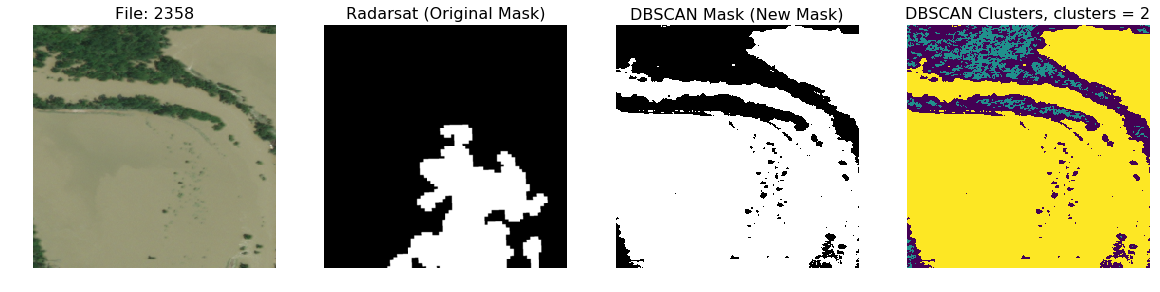

In [764]:
new_mask, mask_clustered, n_clusters_ = dbscan_mask(img,dbscan_train(img, 1.75, 85))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,4,1)

ax1.imshow(img)
ax1.set_title('File: '+str(2358),fontsize= 16,fontname="Times New Roman Bold")
ax1.axis('off')

ax2 = fig.add_subplot(1,4,2)
ax2.imshow(MDA_mask, cmap=plt.cm.gray)
ax2.set_title('Radarsat (Original Mask)',fontsize= 16,fontname="Times New Roman Bold")
ax2.axis('off')

ax3 = fig.add_subplot(1,4,3)
ax3.imshow(new_mask, cmap=plt.cm.gray)
ax3.set_title('DBSCAN Mask (New Mask)',fontsize= 16,fontname="Times New Roman Bold")
ax3.axis('off')

ax4 = fig.add_subplot(1,4,4)
ax4.imshow(mask_clustered)
ax4.set_title('DBSCAN Clusters, clusters = '+str(n_clusters_),fontsize= 16,fontname="Times New Roman Bold")
ax4.axis('off')


/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """
/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


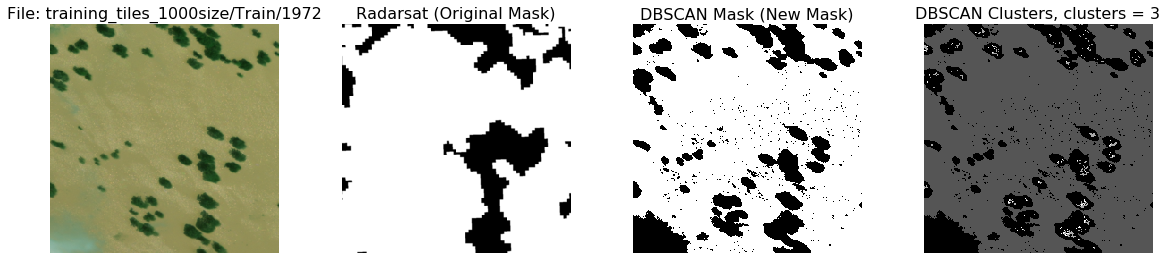

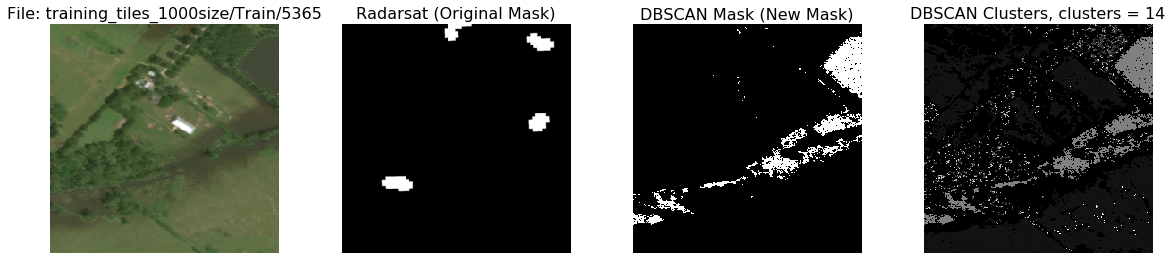

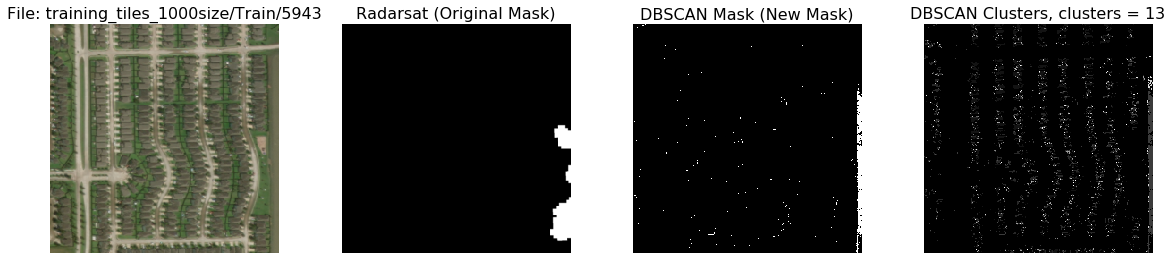

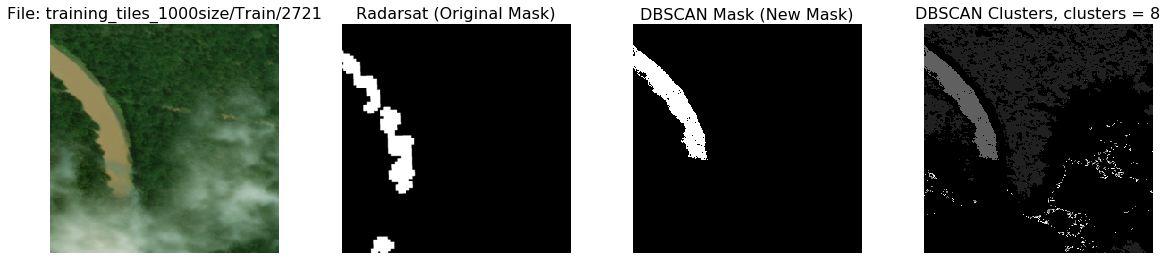

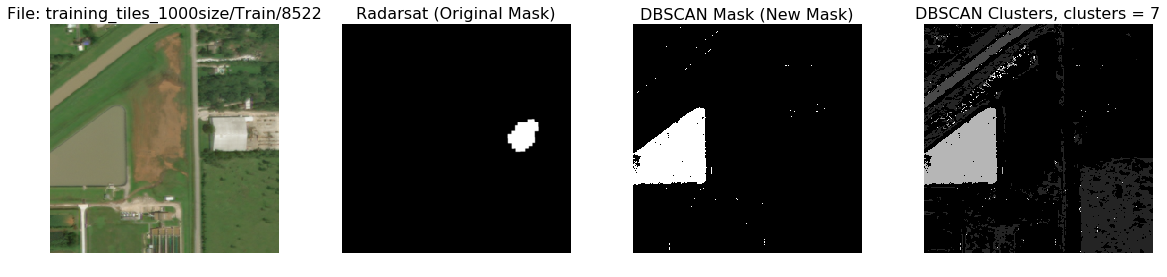

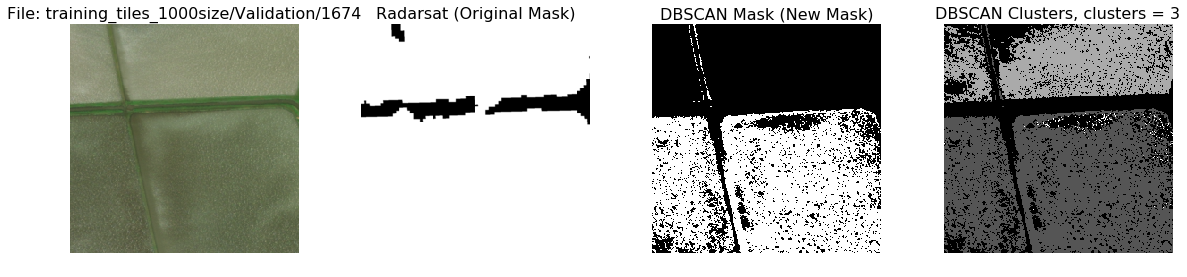

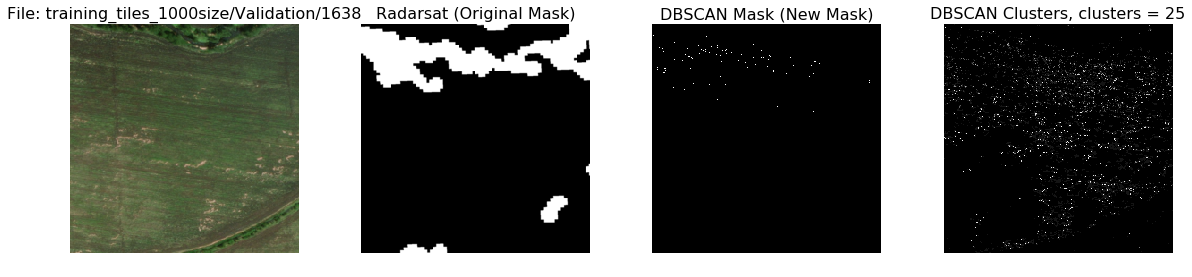

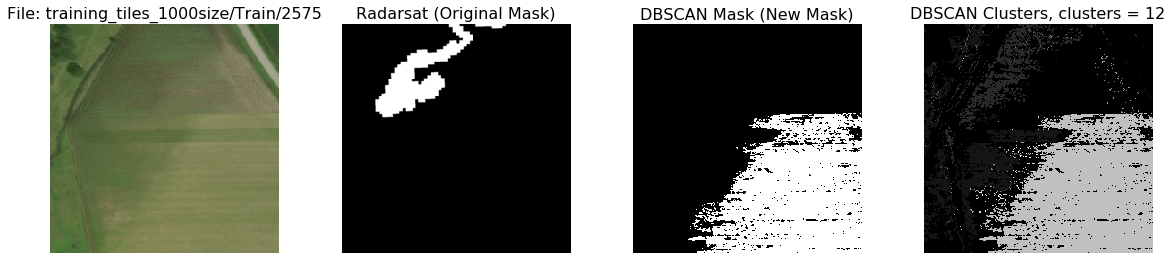

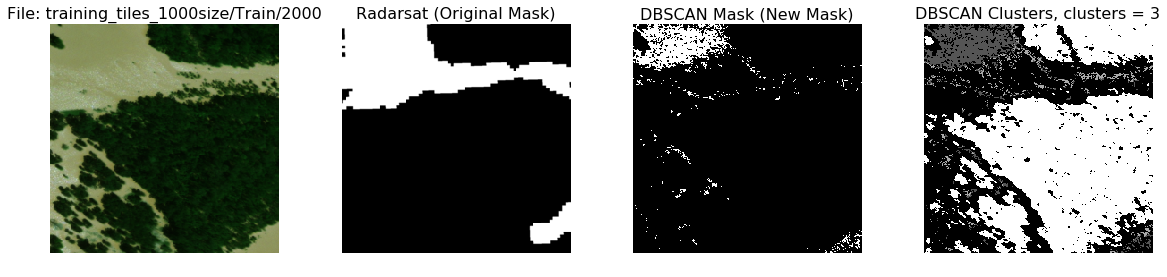

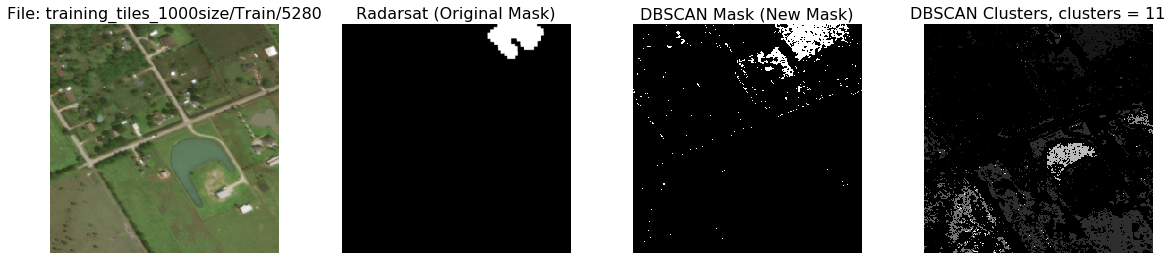

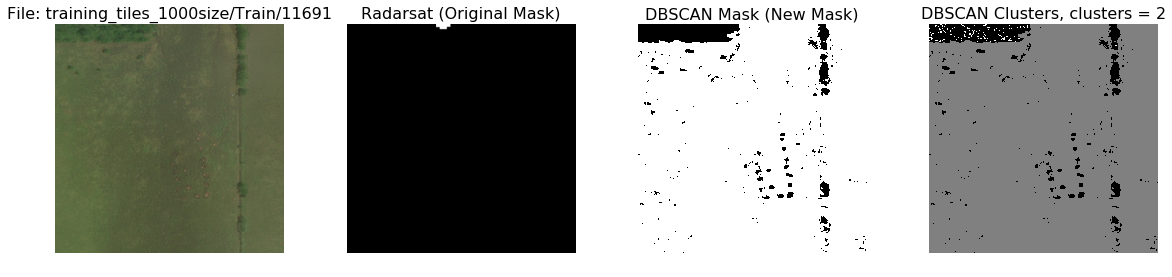

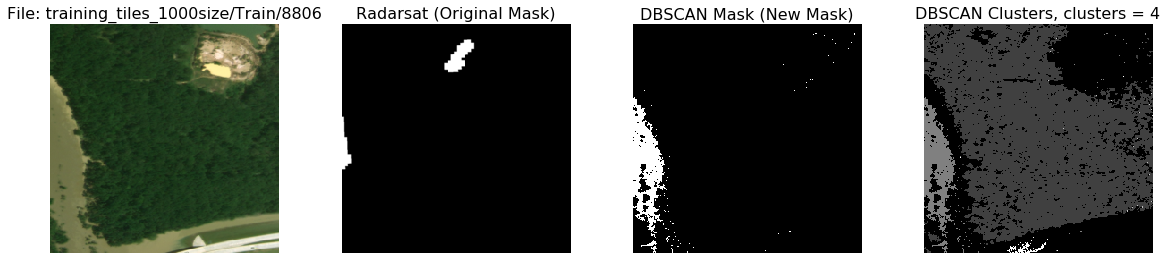

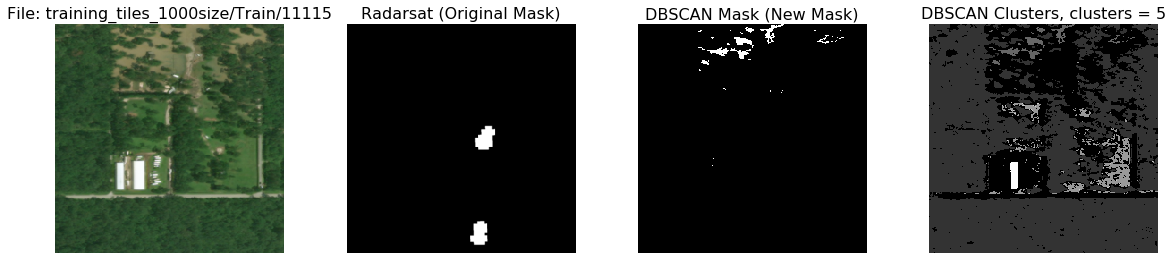

In [766]:
i = 1
num = 20
for random_tiles in np.random.choice(np_files,num,replace=False):
    
    img = imresize(np.load(random_tiles + '_img.npy'),(256,256))
    MDA_mask = imresize(np.load(random_tiles + '_mask.npy'),(256,256))
    
    #print("Image:",random_tiles)
    new_mask_clustered, mask_clustered, n_clusters_ = dbscan_mask(img ,dbscan_train(img, 1.25, 85))

    #Gauss_smoothing = ndimage.gaussian_filter(new_mask_clustered, sigma=(1.2, 1.2))
    #new_mask_smoothed = Gauss_smoothing > 255*0.5                             
    if new_mask_clustered.sum() == 0 :
        continue
    else:
        fig = plt.figure(figsize=(20,num/4*20))
        ax1 = fig.add_subplot(num,4,i)

        ax1.imshow(img)
        ax1.set_title('File: '+random_tiles,fontsize= 16,fontname="Times New Roman Bold")
        ax1.axis('off')

        ax2 = fig.add_subplot(num,4,i+1)
        ax2.imshow(MDA_mask, cmap=plt.cm.gray)
        ax2.set_title('Radarsat (Original Mask)',fontsize= 16,fontname="Times New Roman Bold")
        ax2.axis('off')

        ax3 = fig.add_subplot(num,4,i+2)
        ax3.imshow(new_mask_clustered, cmap=plt.cm.gray)
        ax3.set_title('DBSCAN Mask (New Mask)',fontsize= 16,fontname="Times New Roman Bold")
        ax3.axis('off')

        ax4 = fig.add_subplot(num,4,i+3)
        ax4.imshow(mask_clustered, cmap=plt.cm.gray)
        ax4.set_title('DBSCAN Clusters, clusters = '+str(n_clusters_),fontsize= 16,fontname="Times New Roman Bold")
        ax4.axis('off')

        i+= 4
    

# MISCELLANEOUS

### HDBSCAN

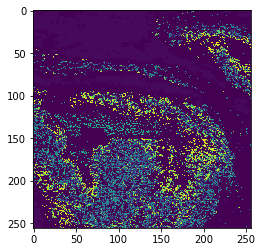

In [5]:
import hdbscan
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40,
    metric='euclidean', min_cluster_size=256, min_samples=None, p=None)
clusterer.fit(Z)
dimension = int(clusterer.labels_.shape[0]**0.5)
mask_clustered2 = np.reshape(clusterer.labels_,(dimension,dimension))
plt.imshow(mask_clustered2)

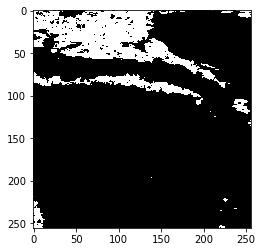

In [8]:
most_common_clusters = Counter(mask_clustered2.flatten()).most_common()
cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws
plt.imshow(255 * (mask_clustered2==cluster_map.keys()[0]),cmap=plt.cm.gray)

### Example 

In [374]:
tile = 'training_tiles_1000size/Train/11223'

img2 = imresize(np.load(tile+'_img.npy'),(256,256))
MDA_mask = imresize(np.load(tile+'_mask.npy'),(256,256))
Z=np.float32(img2.reshape((-1,3)))
db = DBSCAN(eps=1.35,min_samples=85,n_jobs=-1).fit(Z)

#Number of Clusters 
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#Reshping labels into mask of clusters (feature map)
dimension = int(img.shape[0])
mask_clustered = np.reshape(labels, (dimension,dimension))

#Ranking the most common clusters
most_common_clusters = Counter(mask_clustered.flatten()).most_common()
cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group
cluster_map

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


OrderedDict([(1, 26181), (0, 13857), (2, 97)])

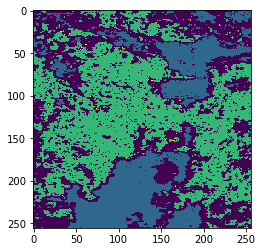

In [376]:
plt.imshow(mask_clustered)

### Testing DBSCAN functions 

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


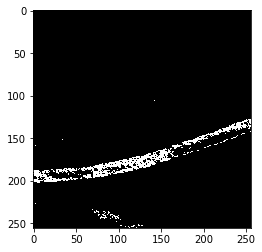

In [759]:
#tile = 'training_tiles_1000size/Train/8046'
#tile = 'training_tiles_1000size/Train/11223'
#tile = 'training_tiles_1000size/Train/5943'
tile = 'training_tiles_1000size/Train/1169'
#tile = 'training_tiles_1000size/Train/4252'

img3 = imresize(np.load(tile+'_img.npy'),(256,256))
new_mask_clustered, mask_clustered, n_clusters_= dbscan_mask(img3,dbscan_train(img3, 1.25, 85))
plt.imshow(new_mask_clustered,cmap=plt.cm.gray)                 

In [652]:
img2 = imresize(np.load(tile+'_img.npy'),(256,256))
MDA_mask = imresize(np.load(tile+'_mask.npy'),(256,256))
Z=np.float32(img2.reshape((-1,3)))
db = DBSCAN(eps=1.2,min_samples=85,n_jobs=-1).fit(Z)

#Number of Clusters 
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#Reshping labels into mask of clusters (feature map)
dimension = int(img.shape[0])
mask_clustered = np.reshape(labels, (dimension,dimension))

#Ranking the most common clusters
most_common_clusters = Counter(mask_clustered.flatten()).most_common()
cluster_map = OrderedDict((k, v) for k, v in most_common_clusters if k >= 0) #gets cluster index, AND throws out the negative-1 group
cluster_map

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.
/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


OrderedDict([(0, 20728),
             (3, 2061),
             (1, 206),
             (4, 160),
             (2, 90),
             (5, 85),
             (7, 71),
             (6, 46)])

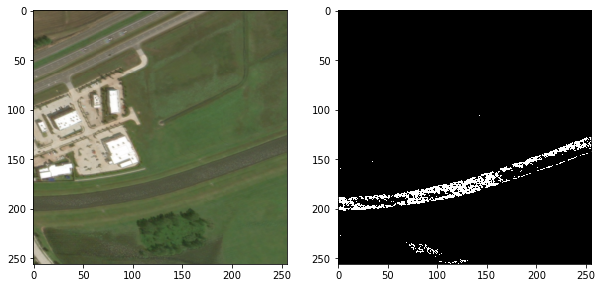

In [655]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img2)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mask_clustered==cluster_map.keys()[1],cmap=plt.cm.gray)


In [601]:
rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))

array([765880, 730048, 643988], dtype=uint64)

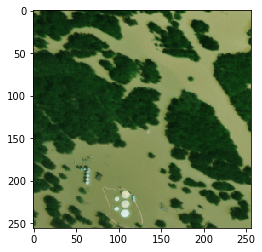

In [230]:
plt.imshow(img)

In [226]:
cluster_map

OrderedDict([(1, 28043), (0, 23469)])

In [227]:
#Filtering out clusters that are too white, black, or green.
for index in cluster_map.keys():
    if len(cluster_map.keys()) == 0:
        new_mask = np.zeros((dimension,dimension))
        break

    #Expanding dimension of a cluster mask and counting the pixels for the RGB channels.
    rgb_sum = (img* np.expand_dims(mask_clustered == index, axis = 2)).sum(axis=(0,1))

    #If cluster is too white or black
    if float(rgb_sum.std())/rgb_sum.mean() < 0.1:
        print("Too white or black",index)
        continue

    #If cluster is too green
    if float(rgb_sum[1])/rgb_sum[0] > 1.1 :
        print("Too much vegatation",index)
        continue

    else:
        new_mask = 255 * (mask_clustered==index)
        break

('Too much vegatation', 1)


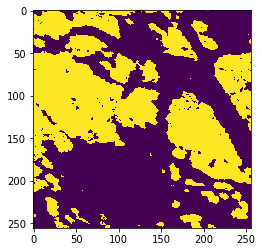

In [229]:
plt.imshow(new_mask)

In [233]:
if not new_mask.all:
    print "no"

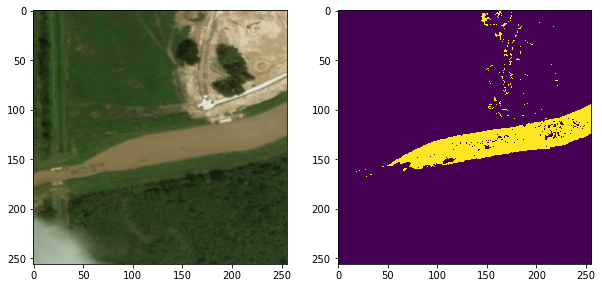

In [134]:
dir_path = 'training_tiles_DBSCAN/'
np_files = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path) 
             for f in files if (f.endswith('img.npy'))]
random_tiles = np.random.choice(np_files,1,replace=False)[0]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(np.load(random_tiles+'_img.npy'))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.load(random_tiles+'_mask.npy'))

In [135]:
((np.load(random_tiles+'_mask.npy')/255).sum()) / (256.0**2)

0.0762786865234375

### OPTICS

In [134]:
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.utils import draw_image_mask_segments, draw_image_color_segments, read_image
from PIL import Image
import scipy

In [135]:
scipy.misc.imsave('test.jpg', img)

/home/mlt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.


In [138]:
data = read_image('test.jpg')

In [147]:
img.tolist()

[[[51, 81, 49],
  [46, 76, 45],
  [47, 78, 46],
  [52, 85, 51],
  [54, 87, 51],
  [53, 84, 49],
  [48, 75, 44],
  [47, 73, 44],
  [47, 75, 47],
  [47, 77, 48],
  [38, 61, 37],
  [36, 56, 34],
  [37, 59, 36],
  [32, 53, 33],
  [28, 47, 29],
  [34, 55, 31],
  [38, 59, 34],
  [38, 60, 35],
  [36, 59, 34],
  [41, 67, 39],
  [50, 82, 50],
  [53, 87, 52],
  [44, 75, 42],
  [44, 76, 40],
  [43, 76, 38],
  [47, 83, 42],
  [46, 84, 44],
  [44, 80, 44],
  [44, 77, 42],
  [43, 71, 38],
  [42, 72, 38],
  [43, 77, 40],
  [46, 81, 43],
  [52, 87, 48],
  [57, 86, 51],
  [67, 92, 56],
  [96, 121, 79],
  [120, 144, 99],
  [121, 139, 101],
  [116, 128, 97],
  [123, 132, 107],
  [140, 146, 121],
  [152, 155, 128],
  [159, 159, 131],
  [170, 167, 141],
  [150, 145, 122],
  [137, 134, 110],
  [143, 144, 115],
  [134, 140, 107],
  [119, 125, 93],
  [124, 127, 97],
  [128, 126, 99],
  [132, 129, 102],
  [142, 137, 109],
  [150, 147, 118],
  [147, 144, 117],
  [140, 140, 114],
  [130, 133, 107],
  [108, 115, 

In [148]:
optics_instance = optics(data, 1.5, 85)

In [157]:
optics_instance.get_clusters()

In [161]:
dbscan_instance = dbscan(data, 1.5, 85, True)

In [162]:
dbscan_instance.get_clusters()

[]